In [ ]:
# import os
# os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# from transformers import pipeline
# import numpy as np
# protgpt2 = pipeline('text-generation', model="/geniusland/home/luojiawei1/project2023/prefix_tuning/cache/finetune/finetune_E100_LR2e-06_BS8_ML200")
# # length is expressed in tokens, where each token has an average length of 4 amino acids.
# sequences = protgpt2("<|endoftext|>", max_length=100, do_sample=True, top_k=950, repetition_penalty=1.2, num_return_sequences=1000, eos_token_id=0)

# seq_list = list()
# for seq in sequences:
#     seq_list.append(seq['generated_text'])
# np.save('/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/finetune_E100_LR2e-06_BS8_ML200_generate.npy' ,seq_list)

In [ ]:
import torch
import math
from transformers import AutoTokenizer, AutoModelForCausalLM
special_token = '<|endoftext|>'
sequence='KSIGKLIFKK'
sequence = special_token + sequence + special_token
#Convert the sequence to a string like this
#(note we have to introduce new line characters every 60 amino acids,
#following the FASTA file format).

# ppl function
def calculatePerplexity(sequence, model, tokenizer):
    input_ids = torch.tensor(tokenizer.encode(sequence)).unsqueeze(0) 
    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
    loss, logits = outputs[:2]
    return math.exp(loss)

#And hence: 
model_path = '/geniusland/home/luojiawei1/project2023/prefix_tuning/cache/fine-tune-model'
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForCausalLM.from_pretrained(model_path)
ppl = calculatePerplexity(sequence, model, tokenizer)
print(ppl)

In [2]:
# 获取prefix和finetune得到的序列
import numpy  as np
import pandas as pd

test_seq_path = '/geniusland/home/luojiawei1/project2023/prefix_tuning/data/AMP/test_amp.csv'
random_seq_list = np.load('/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/AMP/random_seq1000.npy')
pretrain_seq_list = np.load('/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/AMP/pretrain_generate1000_mxlen20_topk500.npy')
finetune_seq_list = np.load('/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/AMP/finetune_E100_LR1e-06_BS32_ML200_generate_mxlen200_topk500.npy')
prefix_seq_list = np.load('/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/AMP/prefix_PREFIX_TUNING_CAUSAL_LM_E100_LR0.001_BS32_ML200_VT20_mxlen200_topk500.npy')

test_seq_csv = pd.read_csv(test_seq_path) # .sample(n=1000)
test_seq_list = [test_seq_csv.iloc[i]['Sequence'].upper() for i in range(len(test_seq_csv))]
aa_list = ['A', 'R', 'N', 'D', 'C', 'E', 'Q', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']

def clean_seq_set(seq_list):
    # 去除序列中多余的字符
    new_seq_list = set()
    other_char_list = set()
    for i, seq in enumerate(seq_list):   # 去除前面的特殊标记 <|endoftext|> '\n'
        seq = seq.replace('\n', '').replace('<|endoftext|>', '')
        seq = seq.replace(' ', '').upper()
        flag = False
        if len(seq) == 0:
            continue
        if len(seq) > 100:   # 去除超过100的序列
            continue
        for aa in seq:
            if aa not in aa_list:
                other_char_list.add(aa)
                flag = True
                break
        if flag:
            continue
        else:
            new_seq_list.add(seq)
    print(other_char_list)
    return list(new_seq_list)

test_seq_list = clean_seq_set(test_seq_list)
random_seq_list = clean_seq_set(random_seq_list)
pretrain_seq_list = clean_seq_set(pretrain_seq_list)
finetune_seq_list = clean_seq_set(finetune_seq_list)
prefix_seq_list = clean_seq_set(prefix_seq_list)

set()
set()
{'X'}
set()
set()


## 统计氨基酸分布

In [4]:
def count_aa_num(seq_list):
    result = {'A': 0, 'R': 0, 'N': 0, 'D': 0, 'C': 0, 'E': 0,
              'Q': 0, 'G': 0, 'H': 0, 'I': 0, 'L': 0, 'K': 0, 'M': 0, 'F': 0, 'P': 0, 'S': 0,
              'T': 0, 'W': 0, 'Y': 0, 'V': 0}
    all_aa_num = sum([len(seq) for seq in seq_list])
    for aa in result.keys():
        for seq in seq_list:
            result[aa] += seq.count(aa)
    for aa in result.keys():
        result[aa] /= all_aa_num
    return result

In [5]:
test_seq_aa_num = count_aa_num(test_seq_list)
random_aa_num = count_aa_num(random_seq_list)
pretrain_aa_num = count_aa_num(pretrain_seq_list)
finetune_aa_num = count_aa_num(finetune_seq_list)
prefix_aa_num = count_aa_num(prefix_seq_list)

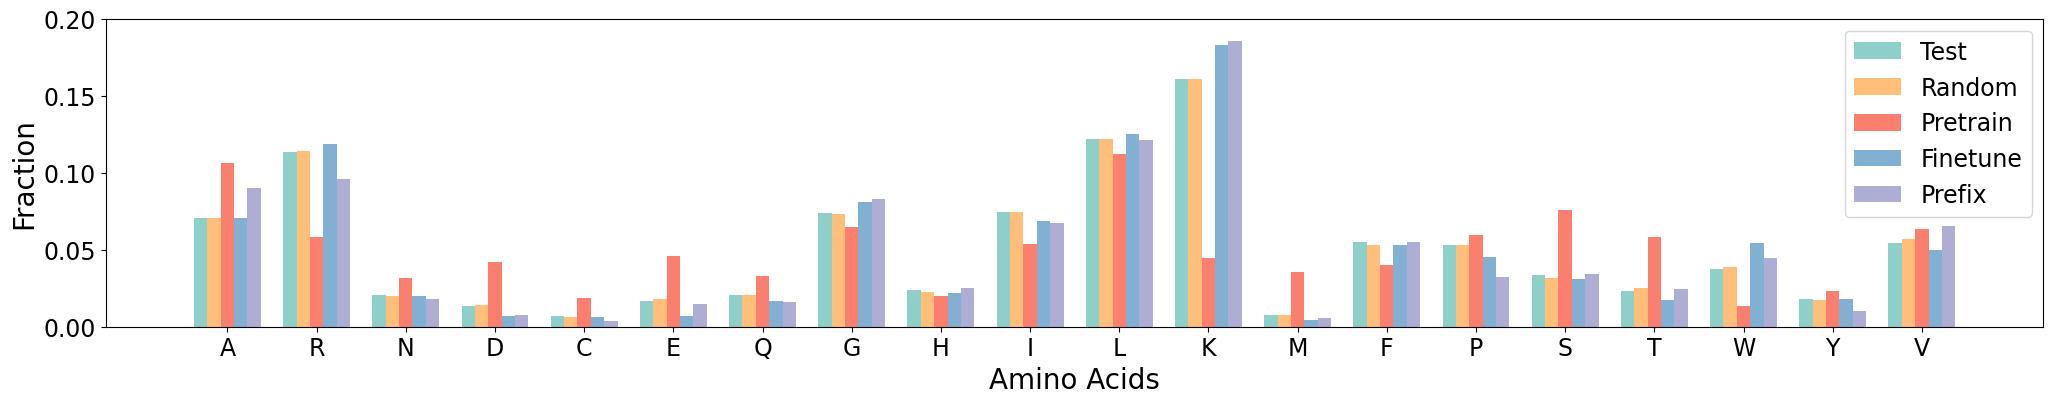

In [6]:
import matplotlib.pyplot as plt
import numpy as np

COLOR_SCALE = ["#8ecfc9", "#ffbe7a", "#fa7f6f", '#82b0d2', '#aeadd3']
# COLOR_SCALE = ["#96cac1", "#f6f6b7", "#c1bed6", '#ea8e83', '#8aafc9']
     
aa_type = list(test_seq_aa_num.keys())
random_seq_aa_num_list = list(random_aa_num.values())
test_seq_aa_num_list = list(test_seq_aa_num.values())
pretrain_seq_aa_num_list = list(pretrain_aa_num.values())
prefix_aa_num_list = list(finetune_aa_num.values())
finetune_aa_num_list = list(prefix_aa_num.values())

fig = plt.figure(figsize=(25,4))
x = np.arange(len(aa_type))

plt.bar(x, test_seq_aa_num_list, width=0.15, color=COLOR_SCALE[0], tick_label=aa_type, label='Test')
plt.bar(x+0.15, random_seq_aa_num_list, width=0.15, color=COLOR_SCALE[1], label='Random')
plt.bar(x+0.3, pretrain_seq_aa_num_list, width=0.15, color=COLOR_SCALE[2], label='Pretrain', tick_label=aa_type)

plt.bar(x+0.45, prefix_aa_num_list, width=0.15,color=COLOR_SCALE[3], label='Finetune')
plt.bar(x+0.6, finetune_aa_num_list, width=0.15,color=COLOR_SCALE[4], label='Prefix')

plt.ylim(0, 0.20)  # 设置 y 轴数值范围
plt.yticks([0, 0.05, 0.10, 0.15, 0.20])  # 设置 y 轴刻度位置
plt.xticks(fontsize=17)  # 设置x轴刻度字体大小
plt.yticks(fontsize=17)  # 设置y轴刻度字体大小
plt.legend(fontsize=17)

plt.xlabel('Amino Acids', fontsize=20)
plt.ylabel('Fraction', fontsize=20)
plt.title("")
# fig.savefig('/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/AMP2/01-img/aa_distri.svg', transparent=True)
plt.show()

In [8]:
test_seq_aa_num_list

[0.07059211611413492,
 0.11375006872285447,
 0.02078179119247897,
 0.013304744625872781,
 0.006982242014404311,
 0.016438506789818022,
 0.020506899774589037,
 0.07378085656165814,
 0.023585683654956294,
 0.07427566111386003,
 0.12216174611028643,
 0.161141349167079,
 0.007587003133762164,
 0.05470339216009676,
 0.05305404365275716,
 0.0338666226840398,
 0.0231458573863324,
 0.0376051459673429,
 0.018197811864313598,
 0.054538457309362805]

## 理化属性分布


In [6]:
import numpy as np
from modlamp.descriptors import PeptideDescriptor, GlobalDescriptor
def get_seq(file_path):
    """
    将numpy的npy文件的序列取出
    """
    import numpy as np
    seq_label_dict = np.load(file_path)
    seq_list = []
    for seq in seq_label_dict:
        if seq == '':
            continue
        seq_list.append(str(seq))
    return seq_list

def get_property(seq_list):
    """
    处理理化性质文件，转化为字典存储，key为10个属性，value为所有的序列对应属性的值
    param: file_path: dppiv理化性质文件，tsv文件，每行为id：x 的10条理化性质
    return：{'Length':[2,3,4,5....], 'MW':[xx,xx,xx.....], 'charge':....}
    """
    Length = []
    MW = []
    charge = []
    ChargeDensity = []
    pI = []
    InstabilityInd = []
    Aromaticity = []
    AliphaticInd = []
    BomanInd = []
    HydrophRatio = []
    for seq in seq_list:  # 读取dict每一个序列
        globdesc = GlobalDescriptor(seq)
        globdesc.calculate_all(ph=7.4,amide=True)
        row=globdesc.descriptor[0]
        Length.append(float(row[0])) # 用列表将对应属性进行存储
        MW.append(float(row[1]))
        charge.append(float(row[2]))
        ChargeDensity.append(float(row[3]))
        pI.append(float(row[4]))
        InstabilityInd.append(float(row[5]))
        Aromaticity.append(float(row[6]))
        AliphaticInd.append(float(row[7]))
        BomanInd.append(float(row[8]))
        HydrophRatio.append(float(row[9]))
        # 属性字典返回
    pro_dict = {'Length':Length, 'MW':MW, 'charge':charge, 'ChargeDensity':ChargeDensity, 'pI':pI, 'InstabilityInd':InstabilityInd, 'Aromaticity':Aromaticity, 'AliphaticInd':AliphaticInd, 'BomanInd':BomanInd, 'HydrophRatio':HydrophRatio}
    return pro_dict

In [8]:
import pandas as pd

# 获取理化属性字典
test_seq_property = get_property(test_seq_list)
pretrain_seq_property = get_property(pretrain_seq_list)
finetune_seq_property = get_property(finetune_seq_list)
prefix_seq_property = get_property(prefix_seq_list)

train_property_df = pd.DataFrame(test_seq_property)
pretrain_property_df = pd.DataFrame(pretrain_seq_property)
finetune_property_df = pd.DataFrame(finetune_seq_property)
prefix_property_df = pd.DataFrame(prefix_seq_property)
# print(finetune_seq_list)

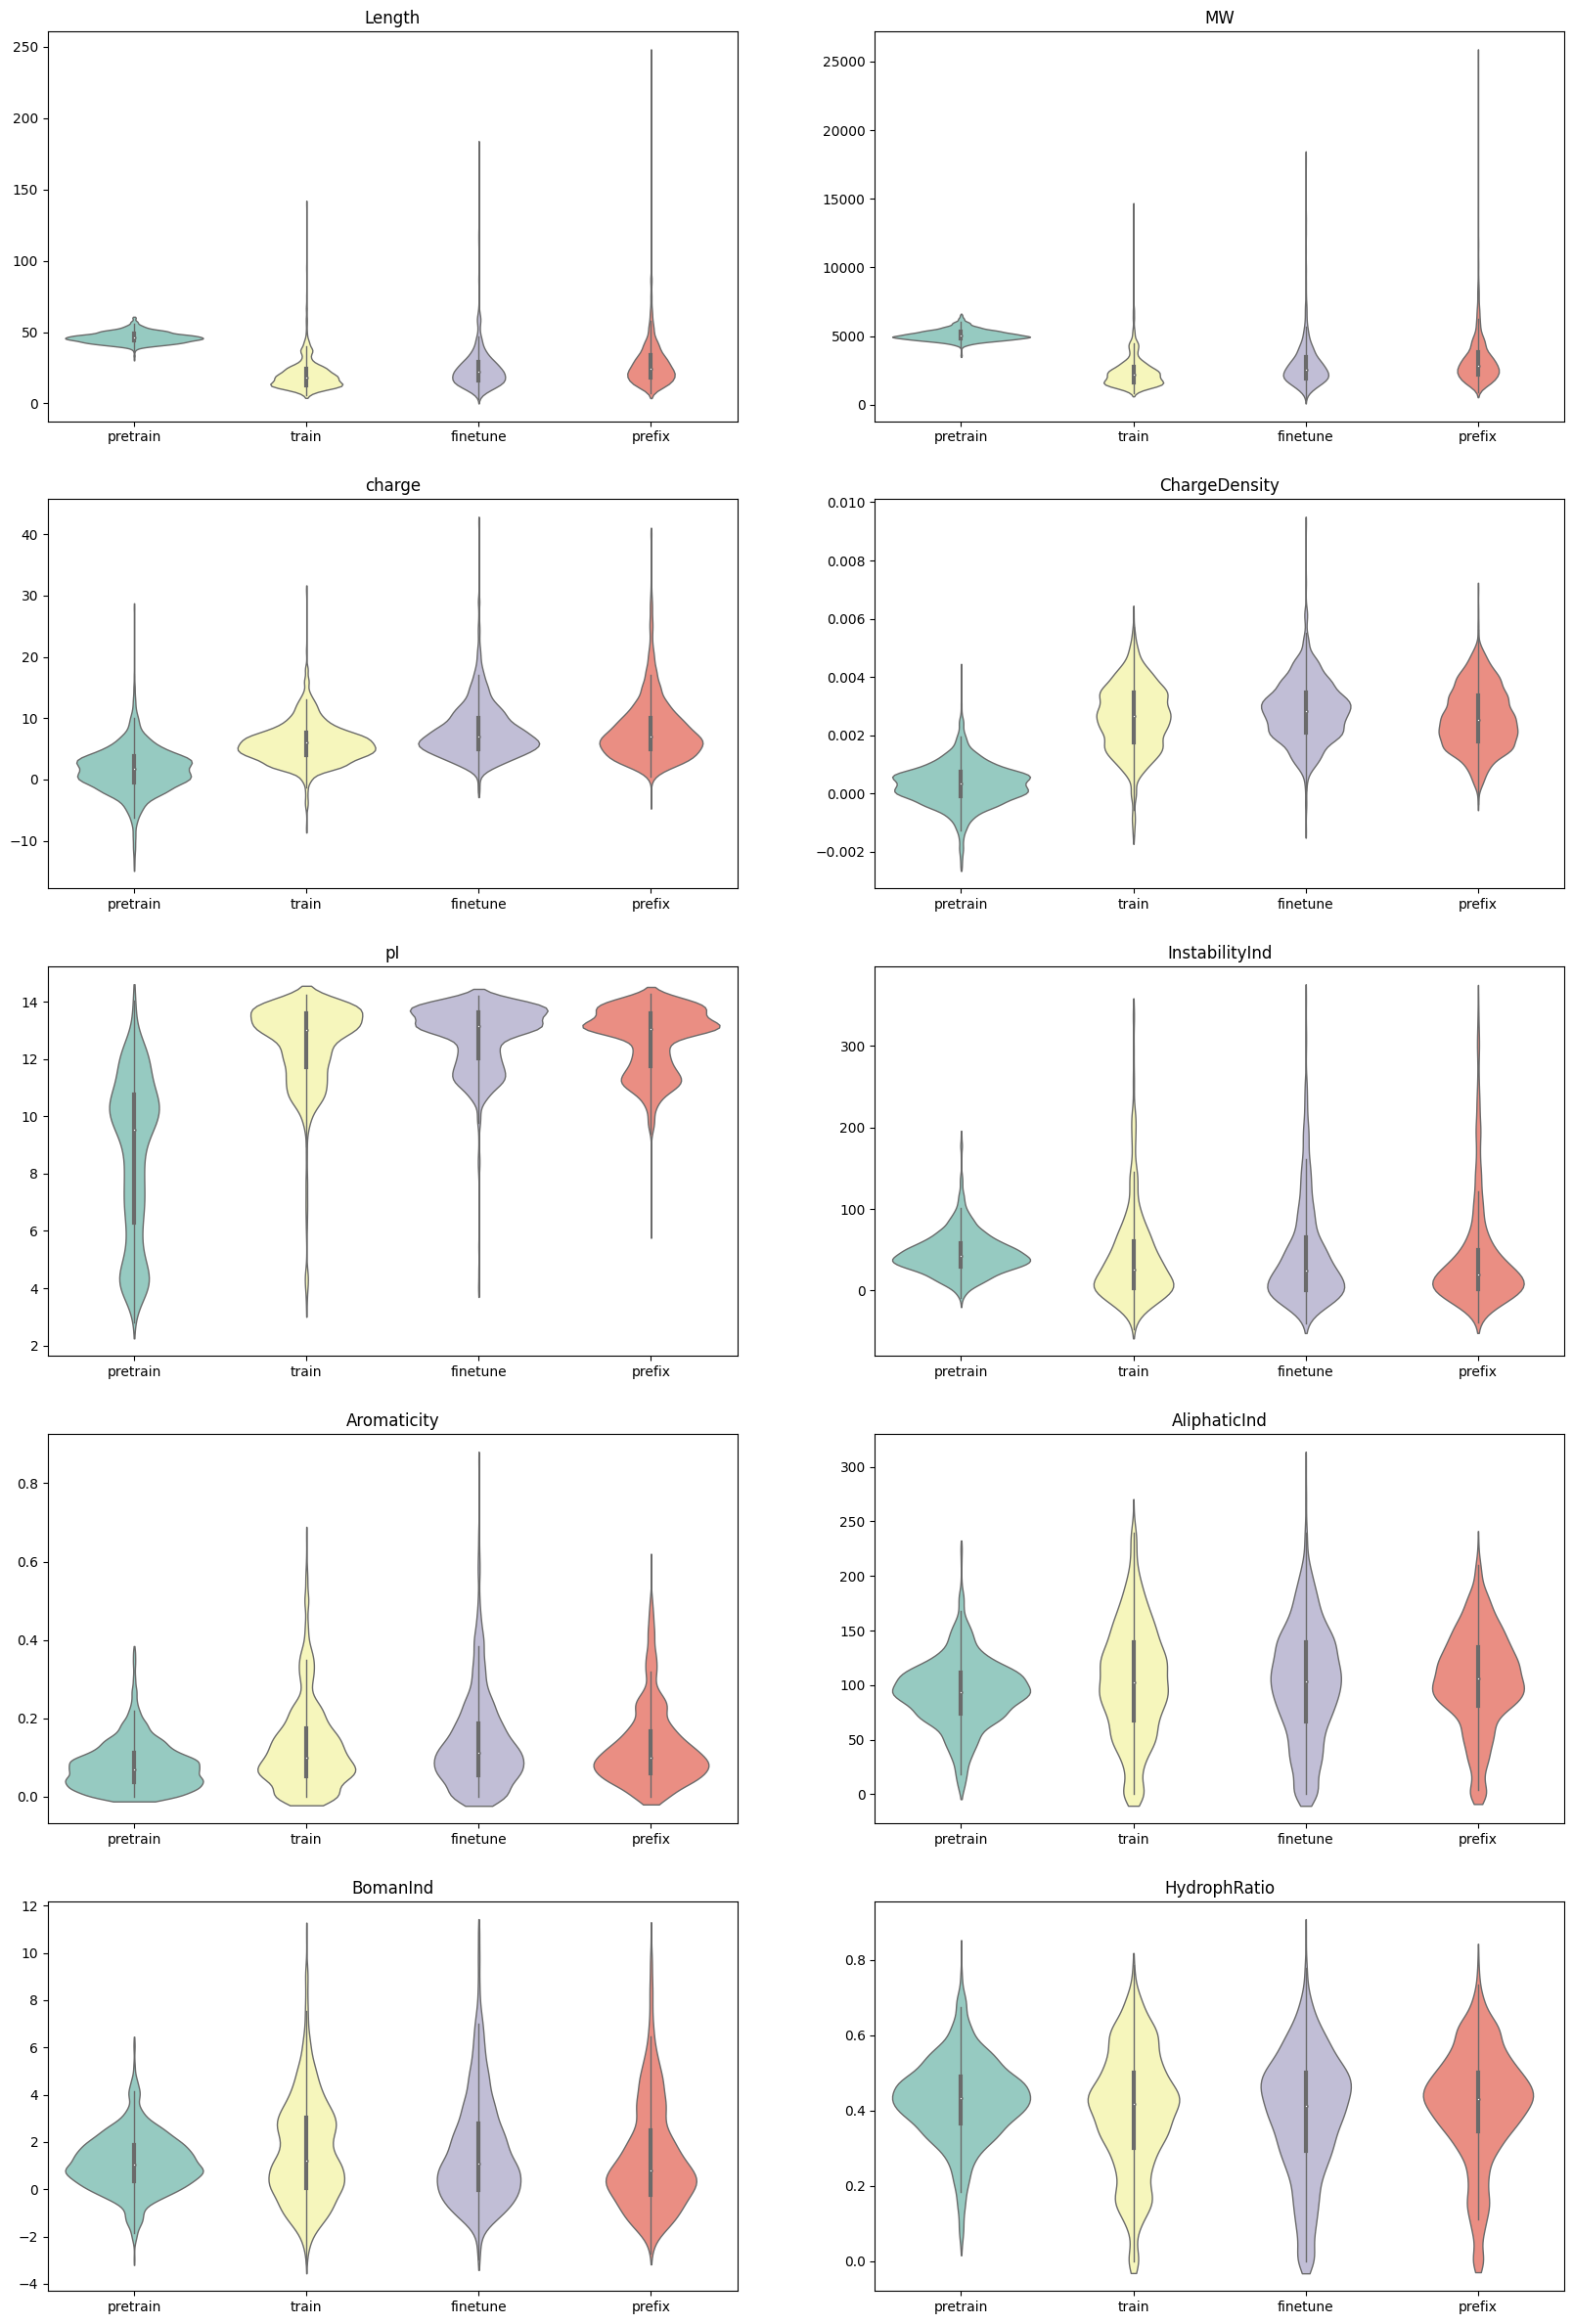

In [9]:
feature_all_list = ['Length', 'MW', 'charge', 'ChargeDensity', 'pI', 'InstabilityInd', 'Aromaticity', 'AliphaticInd', 
                      'BomanInd', 'HydrophRatio']
import seaborn as sns
from matplotlib import pyplot as plt
f = plt.figure(figsize=(20,30))

for i, item in enumerate(feature_all_list):
    ax=plt.subplot(5,2,int(i+1))
    
    c=pd.DataFrame({'pretrain': pretrain_property_df[item], 'train': train_property_df[item], 'finetune': finetune_property_df[item], 'prefix': prefix_property_df[item]})
    sns.violinplot(data=c,palette="Set3", bw=.2, cut=1, linewidth=1)
#    ax.violinplot( G_property[item], 'G', showmeans=True,showmedians=True)
#    ax.violinplot( T_property[item], 'T', showmeans=True,showmedians=True)
    plt.title(item)
# plt.savefig('property.pdf')
plt.show()

# 理化属性

In [8]:
import sys
sys.path.append('..')
from utils import peptide_property as pp

# pretrain_seq_prop = pp.calculate_physchem_prop(pretrain_seq_list)
test_seq_prop = pp.calculate_physchem_prop(test_seq_list)
finetune_seq_prop = pp.calculate_physchem_prop(finetune_seq_list)
prefix_seq_prop = pp.calculate_physchem_prop(prefix_seq_list)
pretrain_seq_prop =  pp.calculate_physchem_prop(pretrain_seq_list)
random_seq_prop =  pp.calculate_physchem_prop(random_seq_list)

test_property_df = pd.DataFrame(test_seq_prop)
random_property_df = pd.DataFrame(random_seq_prop)
pretrain_property_df = pd.DataFrame(pretrain_seq_prop)
finetune_property_df = pd.DataFrame(finetune_seq_prop)
prefix_property_df = pd.DataFrame(prefix_seq_prop)

In [43]:
print(prefix_seq_prop.keys())

dict_keys(['Length', 'Hydrophobicity', 'Hydrophobic moment', 'Charge', 'Charge Density', 'Isoelectric point'])


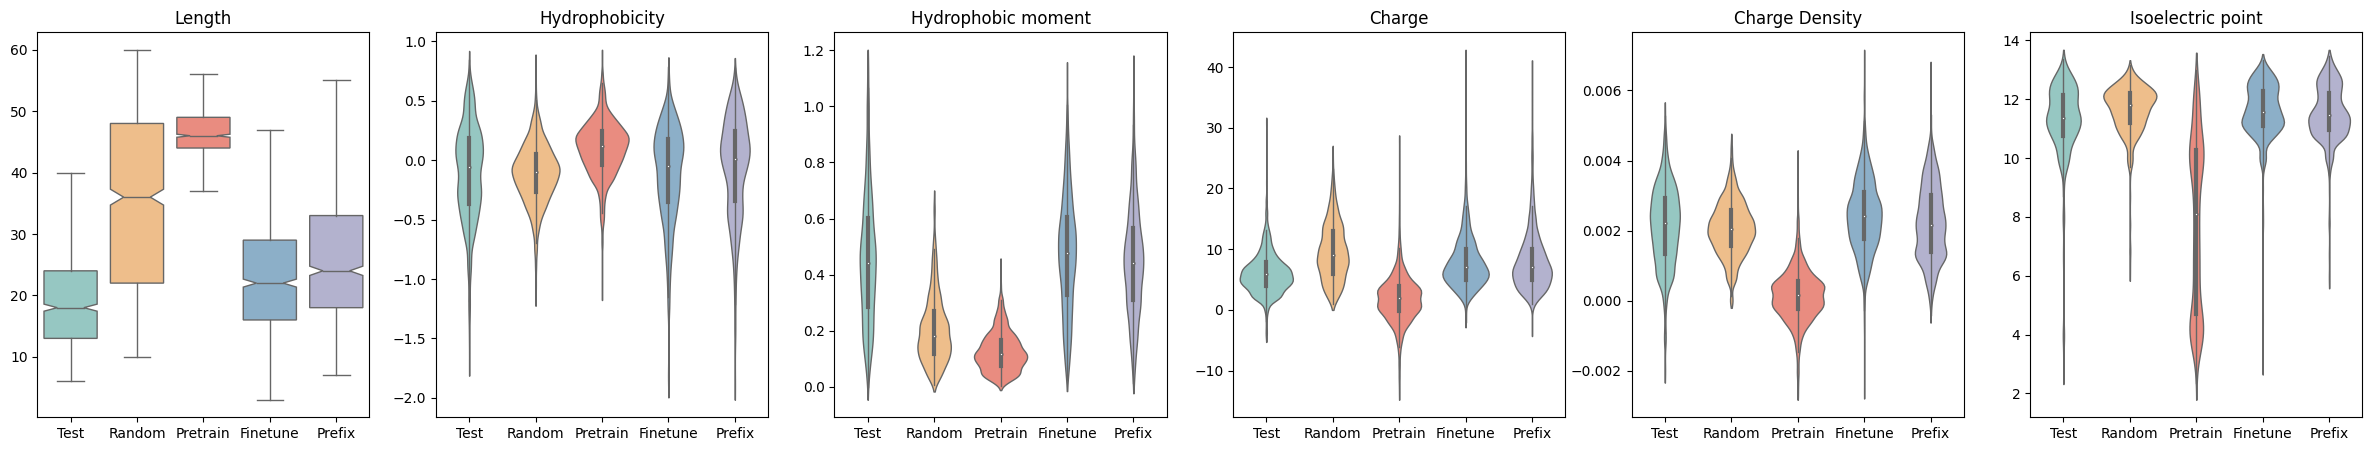

In [9]:
feature_all_list = ['Length', 'Hydrophobicity', 'Hydrophobic moment', 'Charge', 'Charge Density', 'Isoelectric point']
import seaborn as sns
from matplotlib import pyplot as plt
f = plt.figure(figsize=(30,5))
COLOR_SCALE = ["#8ecfc9", "#ffbe7a", "#fa7f6f", '#82b0d2', '#aeadd3']

for i, item in enumerate(feature_all_list):
    ax = plt.subplot(1,6, int(i+1))
    
    c = pd.DataFrame({'Test': test_property_df[item], 'Random':random_property_df[item], 'Pretrain':pretrain_property_df[item],  'Finetune': finetune_property_df[item], 'Prefix': prefix_property_df[item]})
    if item == 'Length':
        sns.boxplot(data=c, linewidth=1, notch=True,showfliers=False, palette=COLOR_SCALE)
    else:
        sns.violinplot(data=c, bw=.2, cut=1, linewidth=1, palette=COLOR_SCALE)
    plt.title(item)
plt.show()

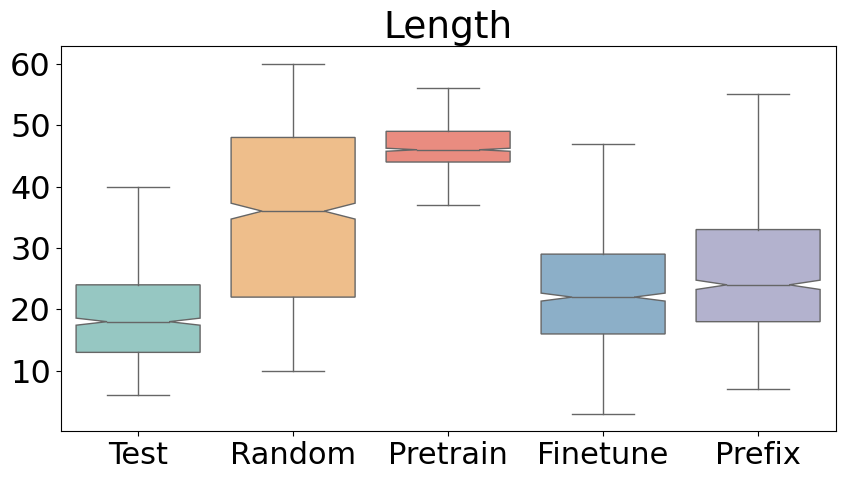

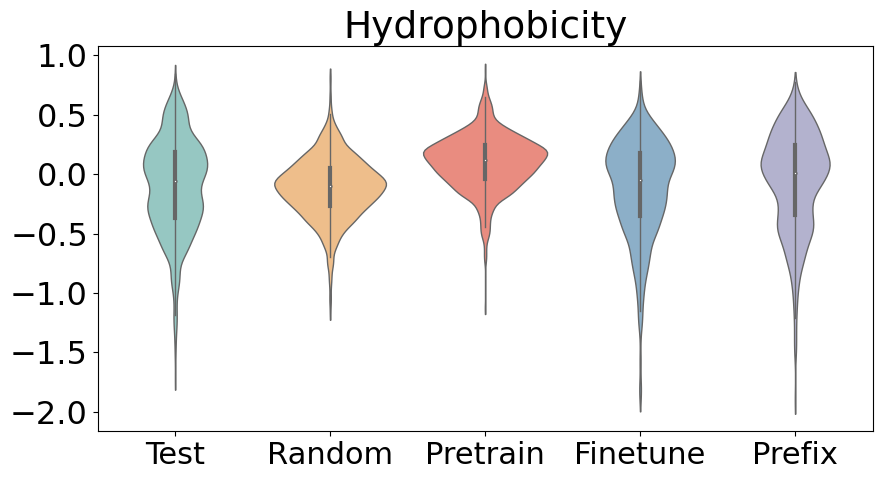

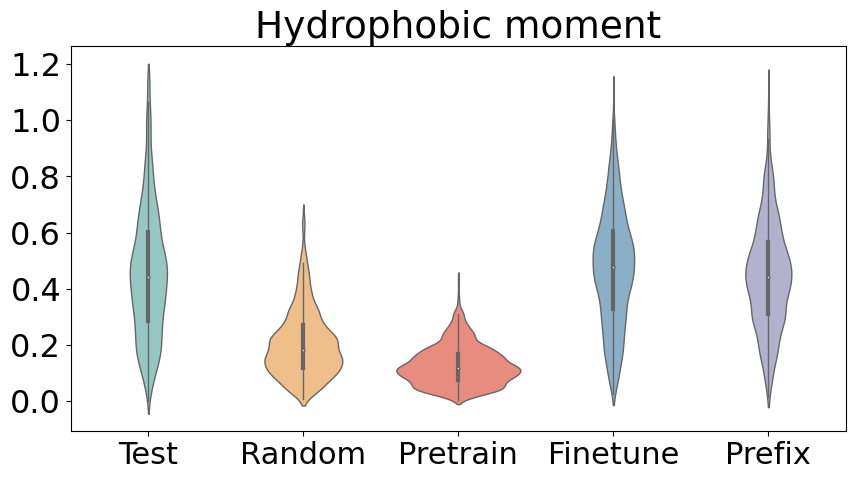

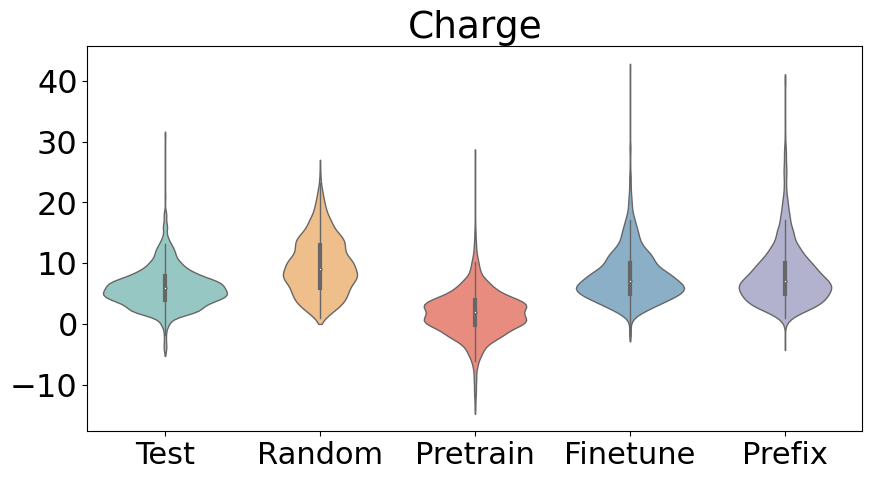

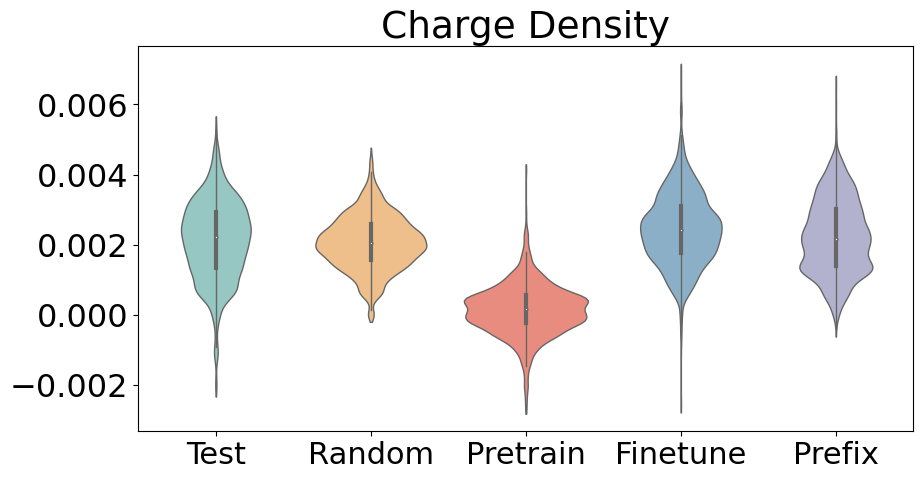

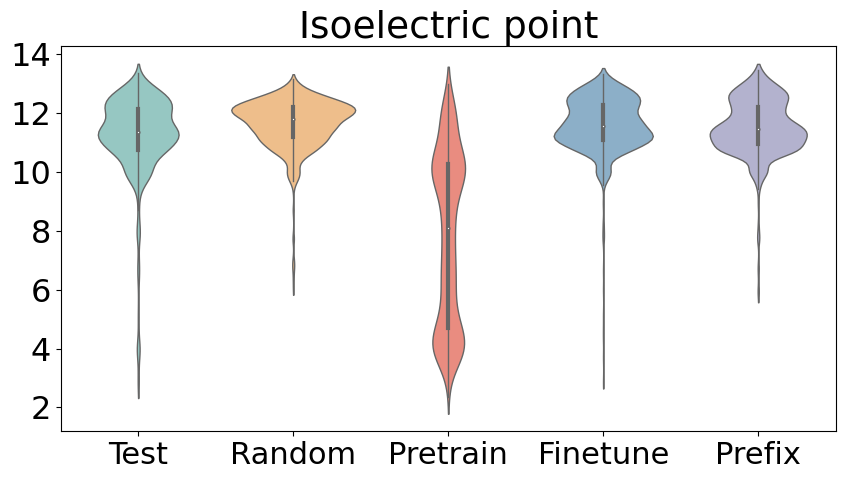

In [10]:
feature_all_list = ['Length', 'Hydrophobicity', 'Hydrophobic moment', 'Charge', 'Charge Density', 'Isoelectric point']

COLOR_SCALE = ["#8ecfc9", "#ffbe7a", "#fa7f6f", '#82b0d2', '#aeadd3']
import seaborn as sns
from matplotlib import pyplot as plt

for i, item in enumerate(feature_all_list):
    f = plt.figure(figsize=(10,5))
    c = pd.DataFrame({'Test': test_property_df[item], 'Random':random_property_df[item], 'Pretrain':pretrain_property_df[item],  'Finetune': finetune_property_df[item], 'Prefix': prefix_property_df[item]})
    if item == 'Length':
        sns.boxplot(data=c,palette=COLOR_SCALE, linewidth=1, notch=True,showfliers=False)
    else:
        sns.violinplot(data=c,palette=COLOR_SCALE, bw=.2, cut=1, linewidth=1)

    plt.xticks(fontsize=22)  # 设置x轴刻度字体大小
    plt.yticks(fontsize=23)  # 设置y轴刻度字体大小

    plt.title(feature_all_list[i], fontsize=27)
    # f.savefig(f'/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/AMP2/01-img/{item}.svg', transparent=True)
    plt.show()


In [5]:
import numpy as np
def get_seq_fasta(file_path, save_dir, name):
    seq_list = np.load(file_path)
    seq_list = clean_seq_set(seq_list)
    with open(save_dir + name + '.fasta', 'w') as f:
        for i, seq in  enumerate(seq_list):
            f.write(f'>{name}_{i}\n')
            f.write(seq + '\n')
save_dir = '/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/ACP_AMP_exp/'
get_seq_fasta('/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/ACP_AMP_exp/concat_amp_acp_mxlen500_topk500.npy', save_dir, 'concat_amp_acp')

# test_seq_csv = pd.read_csv(test_seq_path) # .sample(n=1000)
# test_seq_list = [test_seq_csv.iloc[i]['Sequence'].upper() for i in range(len(test_seq_csv))] 

# lstm_path = '/geniusland/home/luojiawei1/project2023/LSTM_peptides-master/lstm_res1000/sampled_sequences_temp1.25.csv'
# lstm_seq_csv = pd.read_csv(lstm_path) # .sample(n=1000)
# lstm_seq_list = [lstm_seq_csv.iloc[i]['Sequence'].upper() for i in range(len(lstm_seq_csv))]
# with open('/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/AMP/lstm.fasta', 'w') as f:
#     for i, seq in  enumerate(lstm_seq_list):
#         f.write(f'>lstm_{i}\n')
#         f.write(seq + '\n')

{'X', 'U'}


# 比较prefix和其他方法生成序列
LSTM, PepCVAE, Hydramp, prefix, finetune, test

test 0.8250832408435095
finetune 0.8386538461538482
prefix 0.8617793964620218
pepcvae 0.7222100000000002
hydramp 0.6608000000000002
lstm 0.7341313131313149


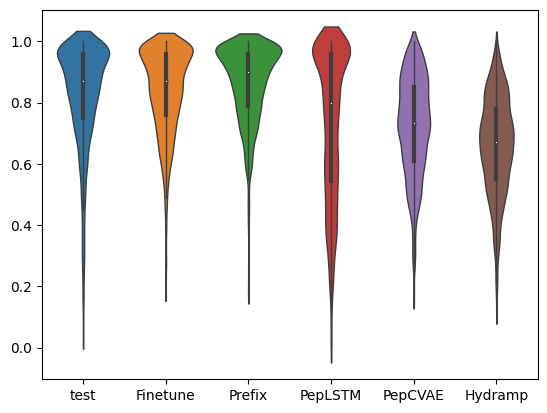

In [12]:
import numpy as np
import pandas as pd
def get_pred(file_path):
    res = []
    with open(file_path) as f:
        for i, raw in enumerate(f.readlines()):
            if i == 0:
                continue
            res.append(float(raw.split('\t')[-1][:-1]))
    return res

test_pred_list = get_pred('/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/AMP2/02-method_compare/test_pred.txt')
finetune_pred_list = get_pred('/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/AMP2/02-method_compare/finetune_seq_pred.txt')
prefix_pred_list = get_pred('/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/AMP2/02-method_compare/prefix_seq_pred.txt')
pepcvae_pred_list = get_pred('/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/AMP2/02-method_compare/pepcvae_pred.txt')
hydramp_pred_list = get_pred('/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/AMP2/02-method_compare/hydramp_pred.txt')
lstm_pred_list = get_pred('/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/AMP2/02-method_compare/lstm_pred.txt')


print('test',sum(test_pred_list)/len(test_pred_list))
print('finetune',sum(finetune_pred_list)/len(finetune_pred_list))
print('prefix',sum(prefix_pred_list)/len(prefix_pred_list))
print('pepcvae',sum(pepcvae_pred_list)/len(pepcvae_pred_list))
print('hydramp',sum(hydramp_pred_list)/len(hydramp_pred_list))
print('lstm',sum(lstm_pred_list)/len(lstm_pred_list))

import seaborn as sns
from matplotlib import pyplot as plt

# c = pd.DataFrame({'Finetune': finetune_pred_list, 'Prefix': prefix_pred_list})
df = pd.DataFrame.from_dict({'test':test_pred_list ,'Finetune': finetune_pred_list, 'Prefix': prefix_pred_list, 'PepLSTM':lstm_pred_list, 'PepCVAE':pepcvae_pred_list, 'Hydramp':hydramp_pred_list}, orient='index')
df = df.transpose()
sns.violinplot(data=df, bw=.2, cut=1, linewidth=1)
plt.show()

# 比较不同数据集训练的情况下生成序列

0.8250832408435095
0.14044132397191603
0.6746451612903238
0.6852591170825337
0.6895707070707073
0.721428571428571
0.7402287581699348
0.8560790273556247
0.8617793964620218


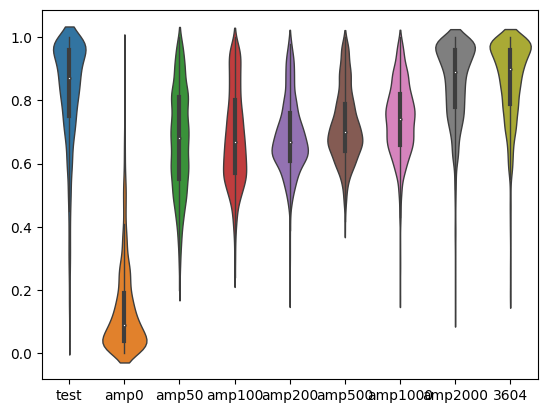

In [13]:
import numpy as np

def get_pred(file_path):
    res = []
    with open(file_path) as f:
        for i, raw in enumerate(f.readlines()):
            if i == 0:
                continue
            res.append(float(raw.split('\t')[-1][:-1]))
    return res
#finetune
# test_pred_list = get_pred('/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/AMP2/02-method_compare/test_pred.txt')
# amp0_pred_list = get_pred('/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/AMP2/03-finetune_low-data/finetune_amp0_seq(pretrain).txt')
# amp50_pred_list = get_pred('/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/AMP2/03-finetune_low-data/finetune_amp50_seq_pred.txt')
# amp100_pred_list = get_pred('/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/AMP2/03-finetune_low-data/finetune_amp100_seq_pred.txt')
# amp200_pred_list = get_pred('/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/AMP2/03-finetune_low-data/finetune_amp200_seq_pred.txt')
# amp500_pred_list = get_pred('/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/AMP2/03-finetune_low-data/finetune_amp500_seq_pred.txt')
# amp1000_pred_list = get_pred('/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/AMP2/03-finetune_low-data/finetune_amp1000_seq_pred.txt')
# amp2000_pred_list = get_pred('/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/AMP2/03-finetune_low-data/finetune_amp2000_seq_pred.txt')
# finetune_pred_list = get_pred('/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/AMP2/02-method_compare/finetune_seq_pred.txt')


#prefix vt20
test_pred_list = get_pred('/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/AMP/02-method_compare/test_pred.txt')
amp0_pred_list = get_pred('/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/AMP2/03-prefix_low-data(vt20)/prefix_amp0_seq(pretrain).txt')
amp50_pred_list = get_pred('/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/AMP2/03-prefix_low-data(vt20)/prefix_amp50_seq_pred.txt')
amp100_pred_list = get_pred('/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/AMP2/03-prefix_low-data(vt20)/prefix_amp100_seq_pred.txt')
amp200_pred_list = get_pred('/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/AMP2/03-prefix_low-data(vt20)/prefix_amp200_seq_pred.txt')
amp500_pred_list = get_pred('/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/AMP2/03-prefix_low-data(vt20)/prefix_amp500_seq_pred.txt')
amp1000_pred_list = get_pred('/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/AMP2/03-prefix_low-data(vt20)/prefix_amp1000_seq_pred.txt')
amp2000_pred_list = get_pred('/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/AMP2/03-prefix_low-data(vt20)/prefix_amp2000_seq_pred.txt')
prefix_pred_list = get_pred('/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/AMP2/02-method_compare/prefix_seq_pred.txt')

# prefix vt50(didnt use)
# test_pred_list = get_pred('/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/AMP/low-data(vt50)/test_pred.txt')
# amp50_pred_list = get_pred('/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/AMP/low-data(vt50)/amp50_pred.txt')
# amp100_pred_list = get_pred('/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/AMP/low-data(vt50)/amp100_pred.txt')
# amp200_pred_list = get_pred('/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/AMP/low-data(vt50)/amp200_pred.txt')
# amp500_pred_list = get_pred('/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/AMP/low-data(vt50)/amp500_pred.txt')
# amp1000_pred_list = get_pred('/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/AMP/low-data(vt50)/amp1000_pred.txt')
# amp2000_pred_list = get_pred('/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/AMP/low-data(vt50)/amp2000_pred.txt')
# prefix_pred_list = get_pred('/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/AMP/compare/prefix_pred.txt')

print(sum(test_pred_list)/len(test_pred_list))
print(sum(amp0_pred_list)/len(amp0_pred_list))
print(sum(amp50_pred_list)/len(amp50_pred_list))
print(sum(amp100_pred_list)/len(amp100_pred_list))
print(sum(amp200_pred_list)/len(amp200_pred_list))
print(sum(amp500_pred_list)/len(amp500_pred_list))
print(sum(amp1000_pred_list)/len(amp1000_pred_list))
print(sum(amp2000_pred_list)/len(amp2000_pred_list))
# print(sum(finetune_pred_list)/len(finetune_pred_list))
print(sum(prefix_pred_list)/len(prefix_pred_list))


import seaborn as sns
from matplotlib import pyplot as plt

# c = pd.DataFrame({'Finetune': finetune_pred_list, 'Prefix': prefix_pred_list})
df = pd.DataFrame.from_dict({'test':test_pred_list, 'amp0':amp0_pred_list, 'amp50': amp50_pred_list, 'amp100': amp100_pred_list, 'amp200':amp200_pred_list, 'amp500':amp500_pred_list, 'amp1000':amp1000_pred_list, 'amp2000':amp2000_pred_list, '3604':prefix_pred_list}, orient='index')
# df = pd.DataFrame.from_dict({'test':test_pred_list, 'amp0':amp0_pred_list, 'amp50': amp50_pred_list, 'amp100': amp100_pred_list, 'amp200':amp200_pred_list, 'amp500':amp500_pred_list, 'amp1000':amp1000_pred_list, 'amp2000':amp2000_pred_list, '3604':finetune_pred_list}, orient='index')

df = df.transpose()
sns.violinplot(data=df, bw=.2, cut=1, linewidth=1)
plt.show()

# 比较不同VT长度对结果影响


test 0.8250832408435095
vt10 0.8613360739979475
vt20 0.8617793964620218
vt30 0.8411328527291474
vt40 0.8582866379310365
vt50 0.8527515400410702
vt60 0.8108016443987672
vt70 0.806395112016294
vt100 0.7811680327868854


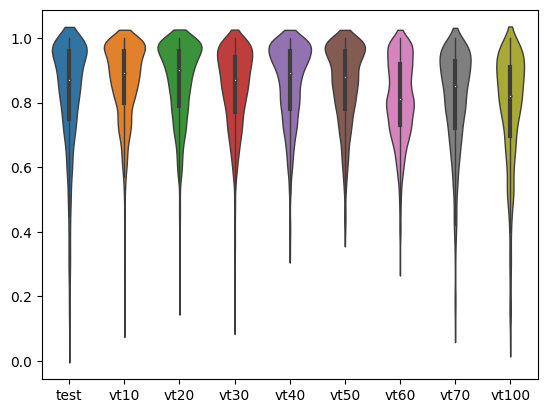

In [14]:
import numpy as np

def get_pred(file_path):
    res = []
    with open(file_path) as f:
        for i, raw in enumerate(f.readlines()):
            if i == 0:
                continue
            res.append(float(raw.split('\t')[-1][:-1]))
    return res
test_pred_list = get_pred('/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/AMP/02-method_compare/test_pred.txt')
vt10_pred_list = get_pred('/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/AMP2/04-vt_test/prefix_VT10_pred.txt')
vt30_pred_list = get_pred('/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/AMP2/04-vt_test/prefix_VT30_pred.txt')
vt40_pred_list = get_pred('/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/AMP2/04-vt_test/prefix_VT40_pred.txt')
vt50_pred_list = get_pred('/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/AMP2/04-vt_test/prefix_VT50_pred.txt')
vt60_pred_list = get_pred('/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/AMP2/04-vt_test/prefix_VT60_pred.txt')
vt70_pred_list = get_pred('/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/AMP2/04-vt_test/prefix_VT70_pred.txt')
vt100_pred_list = get_pred('/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/AMP2/04-vt_test/prefix_VT100_pred.txt')

vt20_pred_list = get_pred('/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/AMP2/02-method_compare/prefix_seq_pred.txt')


print('test', sum(test_pred_list)/len(test_pred_list))
print('vt10', sum(vt10_pred_list)/len(vt10_pred_list))
print('vt20', sum(vt20_pred_list)/len(vt20_pred_list))
print('vt30', sum(vt30_pred_list)/len(vt30_pred_list))
print('vt40', sum(vt40_pred_list)/len(vt40_pred_list))
print('vt50', sum(vt50_pred_list)/len(vt50_pred_list))
print('vt60', sum(vt60_pred_list)/len(vt60_pred_list))
print('vt70', sum(vt70_pred_list)/len(vt70_pred_list))
print('vt100', sum(vt100_pred_list)/len(vt100_pred_list))



import seaborn as sns
from matplotlib import pyplot as plt

# c = pd.DataFrame({'Finetune': finetune_pred_list, 'Prefix': prefix_pred_list})
df = pd.DataFrame.from_dict({'test':test_pred_list, 'vt10': vt10_pred_list, 'vt20': vt20_pred_list, 'vt30':vt30_pred_list, 'vt40':vt40_pred_list, 'vt50':vt50_pred_list, 'vt60':vt60_pred_list, 'vt70':vt70_pred_list, 'vt100':vt100_pred_list}, orient='index')
df = df.transpose()
sns.violinplot(data=df, bw=.2, cut=1, linewidth=1)
plt.show()

# 对prefix生成AMP预测结果进行排序
取出前5绘制车轮图

In [42]:
def get_fasta_seq(fasta_path):
    seq_dict = {}
    with open(fasta_path) as f:
        for raw in f.readlines():
            if raw[0] == '>':
                seq_name = raw[1:-1].upper()
            else:
                seq = raw[:-1]
                seq_dict[seq_name] = seq
        return seq_dict
                
prefix_seq_dict = get_fasta_seq('/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/AMP/compare/prefix_seq.fasta')

def get_pred_dict(file_path):
    res = {}
    with open(file_path) as f:
        for i, raw in enumerate(f.readlines()):
            if i == 0:
                continue
            seq_res = float(raw.split('\t')[-1][:-1])
            seq_name = raw.split('\t')[0]
            res[seq_name] = seq_res
    return res

prefix_pred_dict = get_pred_dict('/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/AMP/compare/prefix_pred.txt')
sort_prefix_pred_dict = sorted(prefix_pred_dict.items(),key = lambda x:x[1],reverse = True)

for seq_name_res in sort_prefix_pred_dict:
    if seq_name_res[1] == 1:
        print(seq_name_res[0], ':', prefix_seq_dict[seq_name_res[0]], 'value:', seq_name_res[1])

VT20_8 : FLPIVKKILSGLF value: 1.0
VT20_35 : GLLSAIKSGLSGLFSAAKAGLSALSK value: 1.0
VT20_93 : LLGTLLKWAANVAGAVVKAIKGKV value: 1.0
VT20_148 : GLFGYLAKAVGKVLPHVVGVIGDYLGGKKP value: 1.0
VT20_179 : GIGNVLKSLLKAGLKAIPAVGKVAGKLLGGK value: 1.0
VT20_184 : GIGGALFSALKKILPKVVKLINKFRKKK value: 1.0
VT20_185 : KWKLFKKVGVAAKVLKHLATVAL value: 1.0
VT20_198 : GLFDIIKKIASKIAGLV value: 1.0
VT20_203 : GWRNIKKVAKNLLHAAKKVWGA value: 1.0
VT20_210 : GIASLLKKIPKIVSGIAKALKWLWRGSRN value: 1.0
VT20_216 : GIGKYLYNVLHGGRTFVGKMFDAAKKVIGLAGRL value: 1.0
VT20_229 : KWKFFKKINKVGKNIHDGLKTGANALKSAAAGTVG value: 1.0
VT20_233 : GIFSALKKLAKKVLPAVVGAIGKFTK value: 1.0
VT20_236 : KWKSFLKTFKSAAKALLKGVLGH value: 1.0
VT20_269 : GLFSIVKHALKAAAKLALNGLIGK value: 1.0
VT20_288 : GIWKSLLKTGAKVAAKVAKKGLVAVATAAAAH value: 1.0
VT20_318 : GIWDKIKGVAKNVVGAAQGALSAIQGGK value: 1.0
VT20_323 : GLRKLLHHGKRAVKRAVLPAVIGAAGVASAL value: 1.0
VT20_329 : ILGALLKAASKVGKHVIKGLISVAGKEQV value: 1.0
VT20_342 : FLPLIKLGAKLLFKGLKKVVK value: 1.0
VT20_356 : GLWSTIG

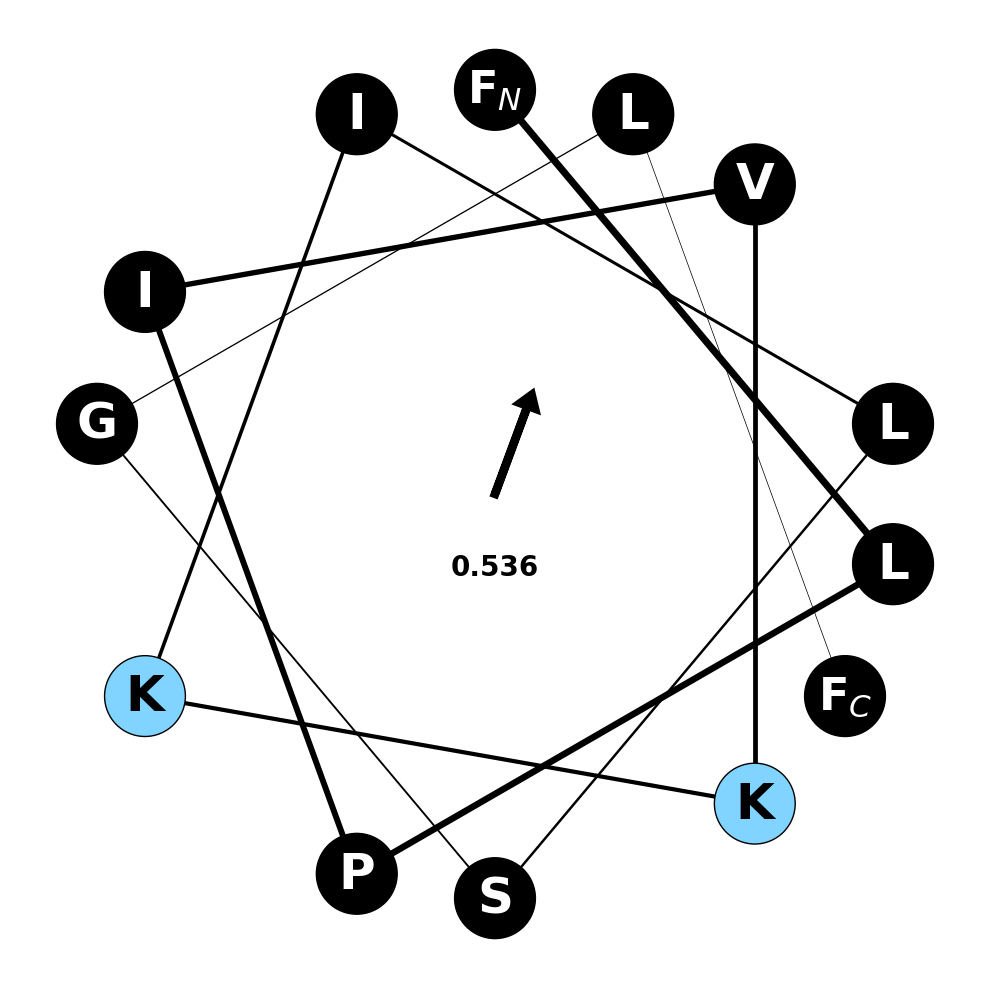

In [11]:
from modlamp.plot import helical_wheel
seq = 'FLPIVKKILSGLF'
# helical_wheel(seq, colorcoding='charge', moment=True, filename=f'/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/AMP/img/heli_wheel/{seq}.svg')
helical_wheel(seq, colorcoding='charge', moment=True)

# FLPIVKKILSGLF
# FLPAIIKGLASILK
# GIASLLKKIPKIVSGIAKALKWLWRGSRN
# GWRNIKKVAKNLLHAAKKVWGA
# VNWKKILGPIVKGIANVAKGSISALNKY

# 可视化

In [15]:
# 不同方法
import pandas as pd
import numpy as np
import random
diff_method_res_dict = {'Test':test_pred_list, 'Prefix': prefix_pred_list, 'Finetune': finetune_pred_list, 'PepLSTM':lstm_pred_list, 'PepCVAE':pepcvae_pred_list, 'Hydramp':hydramp_pred_list}

for t in diff_method_res_dict.keys():
    pred_list = diff_method_res_dict[t]
    diff_method_res_dict[t] = pred_list 
for t in diff_method_res_dict.keys():
    print(t, len(diff_method_res_dict[t]))
expanded_data = [(k, v) for k, lst in diff_method_res_dict.items() for v in lst]
diff_method_res_dict = pd.DataFrame(expanded_data, columns=['Key', 'Value'])

Test 901
Prefix 961
Finetune 988
PepLSTM 990
PepCVAE 1000
Hydramp 1000


In [16]:
# 不同数据量
import pandas as pd
import numpy as np
import random
prefix_diff_data_size_res_dict = {'Test':test_pred_list, '0':amp0_pred_list, '50': amp50_pred_list, '100': amp100_pred_list, '200':amp200_pred_list, '500':amp500_pred_list, '1000':amp1000_pred_list, '2000':amp2000_pred_list, '3604(All)':prefix_pred_list}
# finetune_diff_data_size_res_dict = {'Test':test_pred_list, '0':amp0_pred_list, '50': amp50_pred_list, '100': amp100_pred_list, '200':amp200_pred_list, '500':amp500_pred_list, '1000':amp1000_pred_list, '2000':amp2000_pred_list, '3604(All)':finetune_pred_list}
diff_data_size_res_dict = prefix_diff_data_size_res_dict
for t in diff_data_size_res_dict.keys():
    pred_list = diff_data_size_res_dict[t]
        
    diff_data_size_res_dict[t] = pred_list 
for t in diff_data_size_res_dict.keys():
    print(t, len(diff_data_size_res_dict[t]))
expanded_data = [(k, v) for k, lst in diff_data_size_res_dict.items() for v in lst]
diff_data_size_res_dict = pd.DataFrame(expanded_data, columns=['Key', 'Value'])

Test 901
0 997
50 620
100 521
200 792
500 903
1000 918
2000 987
3604(All) 961


In [32]:
# 不同VT
import pandas as pd
import numpy as np
import random
diff_VT_res_dict = {'Test':test_pred_list, 'VT-10': vt10_pred_list, 'VT-20': vt20_pred_list, 'VT-30':vt30_pred_list, 'VT-40':vt40_pred_list, 'VT-50':vt50_pred_list, 'VT-60':vt60_pred_list, 'VT-70':vt70_pred_list, 'VT-100':vt100_pred_list}

for t in diff_VT_res_dict.keys():
    pred_list = diff_VT_res_dict[t]

    diff_VT_res_dict[t] = pred_list 
for t in diff_VT_res_dict.keys():
    print(t, len(diff_VT_res_dict[t]))
expanded_data = [(k, v) for k, lst in diff_VT_res_dict.items() for v in lst]
diff_VT_res_dict = pd.DataFrame(expanded_data, columns=['Key', 'Value'])

Test 901
VT-10 973
VT-20 961
VT-30 971
VT-40 928
VT-50 974
VT-60 973
VT-70 982
VT-100 976


In [23]:
# 不同的concat方式
# diff_concat_res_dict = {'AMP':prefix_amp_vt20_pred_list, 'Alpha':prefix_alpha_vt20_pred_list, 'Avg_\nAlpha_AMP': avg_prefix_alpha_amp_vt20_pred_list ,'Concat_\nAlpha_AMP': concat_prefix_alpha_amp_pred_list, 'Concat_\nAMP_Alpha':concat_prefix_amp_alpha_pred_list}
diff_concat_res_dict = {'Alpha':prefix_alpha_vt20_pred_list, 'Avg_\nAMP_Alpha': avg_prefix_alpha_amp_vt20_pred_list , 'Concat_\nAMP_Alpha':concat_prefix_amp_alpha_pred_list, 'Avg_\nInit_Alpha':avg_prefix_alpha_init_vt20_pred_list , 'Concat_\nInit_Alpha':concat_prefix_init_alpha_pred_list}

for t in diff_concat_res_dict.keys():
    pred_list = diff_concat_res_dict[t]
    diff_concat_res_dict[t] = pred_list 

for t in diff_concat_res_dict.keys():
    print(t, len(diff_concat_res_dict[t]))
expanded_data = [(k, v) for k, lst in diff_concat_res_dict.items() for v in lst]
diff_concat_res_dict = pd.DataFrame(expanded_data, columns=['Key', 'Value'])

Alpha 254
Avg_
AMP_Alpha 827
Concat_
AMP_Alpha 796
Avg_
Init_Alpha 358
Concat_
Init_Alpha 115


In [24]:
# data_dict = diff_method_res_dict
# data_dict = diff_data_size_res_dict
# data_dict = diff_VT_res_dict
data_dict = diff_concat_res_dict

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

# Get the methods type, sorted alphabetically
# method_types = sorted(all_data_seq_dssp_hrate_df["Key"].unique())
method_types = data_dict["Key"].unique()
print(method_types)

# y_data is a list of length 3 containing the bill_length_mm values for each specie 
y_data = [data_dict[data_dict["Key"] == method]["Value"].values for method in method_types]

# Create jittered version of "x" (which is only 0, 1, and 2)
# More about this in the bonus track!
jitter = 0.04
x_data = [np.array([i] * len(d)) for i, d in enumerate(y_data)]
x_jittered = [x + st.t(df=6, scale=jitter).rvs(len(x)) for x in x_data]

# Colors
BG_WHITE = "#FFFFFF"
GREY_LIGHT = "#b4aea9"
GREY50 = "#7F7F7F"
BLUE_DARK = "#1B2838"
BLUE = "#2a475e"
BLACK = "#282724"
GREY_DARK = "#747473"
RED_DARK = "#850e00"

# Colors taken from Dark2 palette in RColorBrewer R library
COLOR_SCALE = ["#edbdb9", "#bbcadc", "#d0e6cb", '#dbcee1', '#f0d8b3', '#BED4E7', '#B8D8BA', '#E5B061', '#FFC2D1']

# Horizontal positions for the violins. 
# They are arbitrary numbers. They could have been [-1, 0, 1] for example.
# POSITIONS = [0, 1, 2, 3, 4, 5,6,7,8]
POSITIONS = [0, 1, 2, 3, 4]
# Horizontal lines
HLINES = [0.2, 0.4, 0.6, 0.8]

['Alpha' 'Avg_\nAMP_Alpha' 'Concat_\nAMP_Alpha' 'Avg_\nInit_Alpha'
 'Concat_\nInit_Alpha']


{'whiskers': [<matplotlib.lines.Line2D at 0x7f2f100c1fa0>,
 'caps': [],
 'boxes': [<matplotlib.lines.Line2D at 0x7f2f100c1d00>,
 'medians': [<matplotlib.lines.Line2D at 0x7f2f11a85520>,
 'fliers': [],
 'means': []}

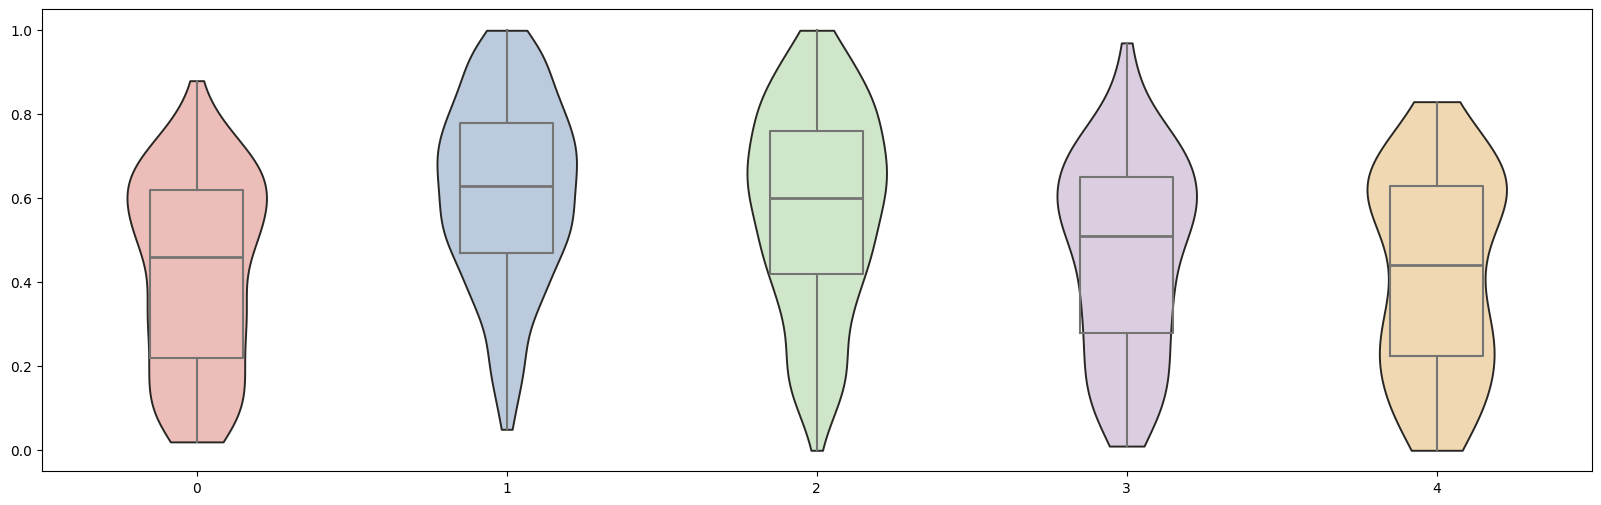

In [28]:
fig, ax = plt.subplots(figsize= (20, 6))
# fig, ax = plt.subplots(figsize= (34, 6))

# Some layout stuff ----------------------------------------------
# Background color
fig.patch.set_facecolor(BG_WHITE)
ax.set_facecolor(BG_WHITE)


# Add violins ----------------------------------------------------

# The output is stored in 'violins', used to customize their appearence
violins = ax.violinplot(
    y_data, 
    positions=POSITIONS,
    widths=0.45,
    bw_method="silverman",
    showmeans=False, 
    showmedians=False,
    showextrema=False,
)

# Customize violins (remove fill, customize line, etc.)
for pc, color in zip(violins['bodies'], COLOR_SCALE):
    pc.set_facecolor(color)
    pc.set_edgecolor(BLACK)
    pc.set_linewidth(1.4)
    pc.set_alpha(1)

# Add boxplots ---------------------------------------------------
# Note that properties about the median and the box are passed as dictionaries.
medianprops = dict(
    linewidth=2, 
    color=GREY_DARK,
    solid_capstyle="butt"
)
boxprops = dict(
    linewidth=1.5, 
    color=GREY_DARK,
)

ax.boxplot(
    y_data,
    widths=0.3,
    positions=POSITIONS, 
    showfliers = False, # Do not show the outliers beyond the caps.
    showcaps = False,   # Do not show the caps
    medianprops = medianprops,
    whiskerprops = boxprops,
    boxprops = boxprops
)

# Add jittered dots ----------------------------------------------
# for x, y, color in zip(x_jittered, y_data, COLOR_SCALE):
#     ax.scatter(x, y, s = 100, color=color, alpha=0.4)

['Alpha' 'Avg_\nAMP_Alpha' 'Concat_\nAMP_Alpha' 'Avg_\nInit_Alpha'
 'Concat_\nInit_Alpha']


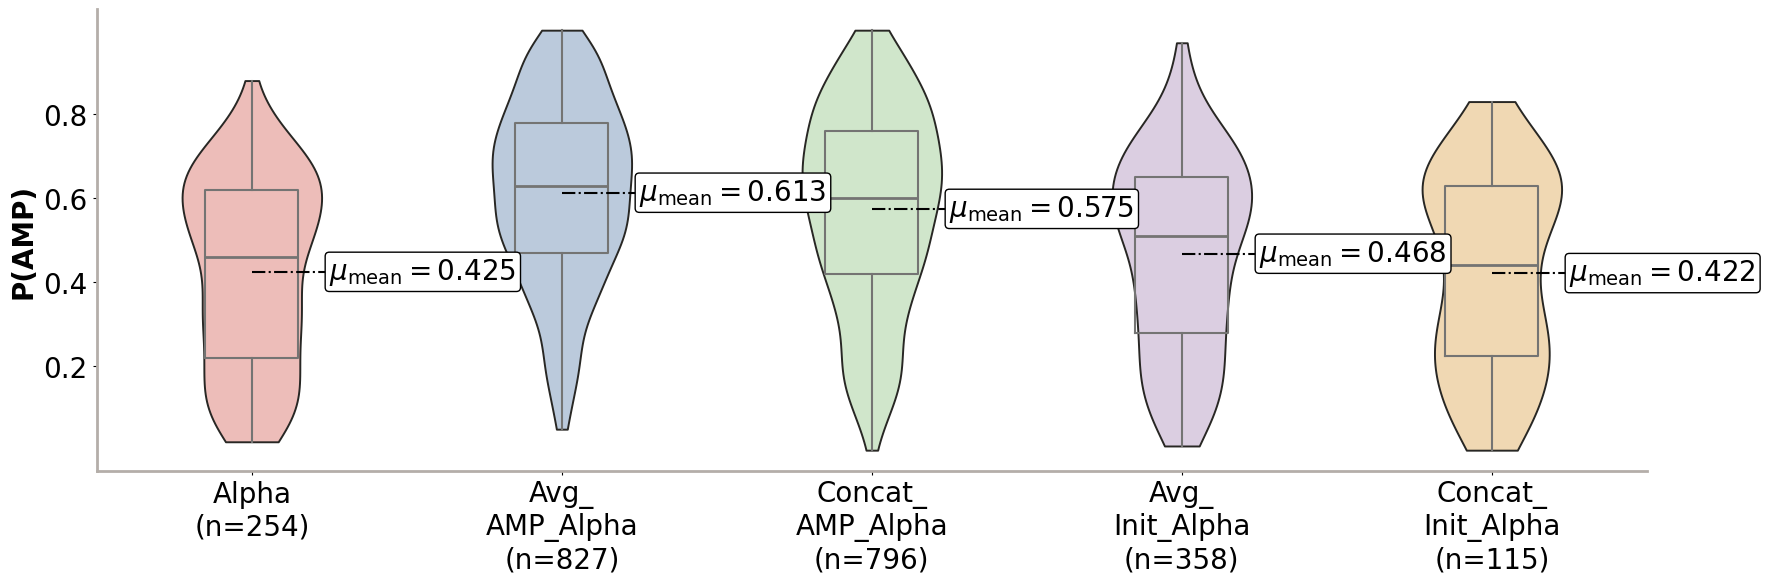

In [29]:
# Add mean value labels ------------------------------------------
means = [y.mean() for y in y_data]
for i, mean in enumerate(means):
    # Add dot representing the mean
    # ax.scatter(i, mean, s=250, color=RED_DARK, zorder=3)
    
    # Add line conecting mean value and its label
    ax.plot([i, i + 0.25], [mean, mean], ls="dashdot", color="black", zorder=3)
    
    # Add mean value label.
    ax.text(
        i + 0.25,
        mean,
        r"${\mu}_{\rm{mean}} = $" + str(round(mean, 3)),
        fontsize=20,   # 20  15
        va="center",
        bbox = dict(
            facecolor="white",
            edgecolor="black",
            boxstyle="round",
            pad=0.15
        ),
        zorder=10 # to make sure the line is on top
    )

# Customize layout -----------------------------------------------
# Hide spines
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")

# Customize spines color
ax.spines["left"].set_color(GREY_LIGHT)
ax.spines["left"].set_linewidth(2)
ax.spines["bottom"].set_color(GREY_LIGHT)
ax.spines["bottom"].set_linewidth(2)

# Customize labels and ticks
ax.tick_params(length=3)
ax.set_yticks(HLINES)
ax.set_yticklabels(HLINES, size=20)
ax.set_ylabel("P(AMP)", size=20, weight="bold")
# ax.set_xlabel("Methods", size=20, weight="bold")
# xlabels accounts for the sample size for each species
# 修改X坐标值
for i in range(len(method_types)):
    if 'prefix' in method_types[i]:
        method_types[i] = 'Prefix'
    else:
        name = method_types[i][0].upper() + method_types[i][1:]
        method_types[i] = name
print(method_types)
xlabels = [f"{method_type}\n(n={y_data[i].size})" for i, method_type in enumerate(method_types)]
ax.set_xticks(POSITIONS)
ax.set_xticklabels(xlabels, size=20, ha="center", ma="center")
# ax.set_xlabel("Prefix length", size=18, weight="bold")

fig

In [30]:
fig.savefig('/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/AMP2/01-img/concat/amp_concat_compare.svg', transparent=True) 

# prefix拼接

prefix_alpha_vt20_pred 0.4246062992125984
avg_prefix_alpha_amp_vt20_pred 0.6130108827085853
concat_prefix_amp_alpha_pred 0.5745100502512557
avg_prefix_alpha_init_vt20_pred 0.467765363128492
concat_prefix_init_alpha_pred 0.4216521739130435


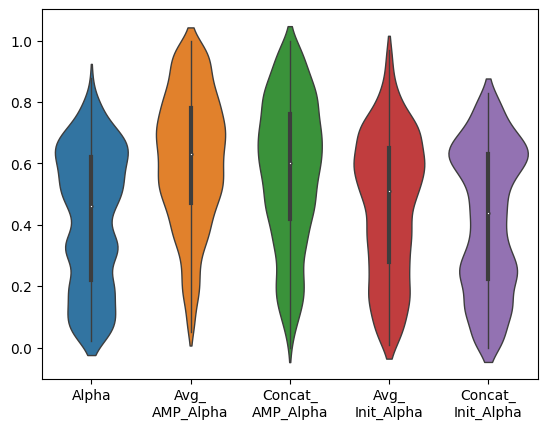

In [22]:
import numpy as np
import pandas as pd
def get_pred(file_path):
    res = []
    with open(file_path) as f:
        for i, raw in enumerate(f.readlines()):
            if i == 0:
                continue
            res.append(float(raw.split('\t')[-1][:-1]))
    return res

prefix_alpha_vt20_pred_list = get_pred('/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/concat/prefix_alpha_vt20/prefix_alpha_vt20_pred.txt')
# prefix_amp_vt20_pred_list = get_pred('/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/concat/prefix_amp_vt20/prefix_amp_vt20_pred.txt')
prefix_init_vt20_pred_list = get_pred('/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/concat/init_prefix_vt20/init_prefix_vt20_pred.txt')
avg_prefix_alpha_amp_vt20_pred_list = get_pred('/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/concat/avg_prefix_alpha_amp_vt20/avg_prefix_alpha_amp_vt20_pred.txt')
# concat_prefix_alpha_amp_pred_list = get_pred('/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/concat/concat_prefix_alpha_amp/concat_prefix_alpha_amp_pred.txt')
concat_prefix_amp_alpha_pred_list = get_pred('/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/concat/concat_prefix_amp_alpha/concat_prefix_amp_alpha_pred.txt')

avg_prefix_alpha_init_vt20_pred_list = get_pred('/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/concat/avg_prefix_alpha_init_vt20/avg_prefix_alpha_init_vt20_pred.txt')
# concat_prefix_alpha_init_pred_list = get_pred('/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/concat/concat_prefix_alpha_init/concat_prefix_alpha_init_pred.txt')
concat_prefix_init_alpha_pred_list = get_pred('/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/concat/concat_prefix_init_alpha/concat_prefix_init_alpha_pred.txt')

print('prefix_alpha_vt20_pred',sum(prefix_alpha_vt20_pred_list)/len(prefix_alpha_vt20_pred_list))
# print('prefix_init_vt20_pred',sum(prefix_init_vt20_pred_list)/len(prefix_init_vt20_pred_list))
# print('prefix_amp_vt20_pred',sum(prefix_amp_vt20_pred_list)/len(prefix_amp_vt20_pred_list))
print('avg_prefix_alpha_amp_vt20_pred',sum(avg_prefix_alpha_amp_vt20_pred_list)/len(avg_prefix_alpha_amp_vt20_pred_list))
print('concat_prefix_amp_alpha_pred',sum(concat_prefix_amp_alpha_pred_list)/len(concat_prefix_amp_alpha_pred_list))
# print('concat_prefix_alpha_amp_pre',sum(concat_prefix_alpha_amp_pred_list)/len(concat_prefix_alpha_amp_pred_list))

print('avg_prefix_alpha_init_vt20_pred',sum(avg_prefix_alpha_init_vt20_pred_list)/len(avg_prefix_alpha_init_vt20_pred_list))
print('concat_prefix_init_alpha_pred',sum(concat_prefix_init_alpha_pred_list)/len(concat_prefix_init_alpha_pred_list))
# print('concat_prefix_alpha_init_pred',sum(concat_prefix_alpha_init_pred_list)/len(concat_prefix_alpha_init_pred_list))
import seaborn as sns
from matplotlib import pyplot as plt

# c = pd.DataFrame({'Finetune': finetune_pred_list, 'Prefix': prefix_pred_list})
# df = pd.DataFrame.from_dict({'Alpha':prefix_alpha_vt20_pred_list, 'AMP':prefix_amp_vt20_pred_list,'Avg_\nAlpha_AMP': avg_prefix_alpha_amp_vt20_pred_list ,'Concat_\nAlpha_AMP': concat_prefix_alpha_amp_pred_list, 'Concat_\nAMP_Alpha':concat_prefix_amp_alpha_pred_list}, orient='index')
df = pd.DataFrame.from_dict({'Alpha':prefix_alpha_vt20_pred_list, 'Avg_\nAMP_Alpha': avg_prefix_alpha_amp_vt20_pred_list , 'Concat_\nAMP_Alpha':concat_prefix_amp_alpha_pred_list, 'Avg_\nInit_Alpha':avg_prefix_alpha_init_vt20_pred_list , 'Concat_\nInit_Alpha':concat_prefix_init_alpha_pred_list}, orient='index')


df = df.transpose()
sns.violinplot(data=df, bw=.2, cut=1, linewidth=1)
plt.show()

In [17]:
def get_seq(file_path):
    seq_list = []
    with open(file_path) as f:
        for raw in f.readlines():
            if raw[0]  == '>':
                continue
            seq_list.append(raw[:-1])
    return seq_list


avg_prefix_alpha_amp_vt20_list = get_seq('/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/concat/avg_prefix_alpha_amp_vt20/avg_prefix_alpha_amp_vt20.fasta')
concat_prefix_amp_alpha_list = get_seq('/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/concat/concat_prefix_amp_alpha/concat_prefix_amp_alpha.fasta')
# concat_prefix_alpha_amp_list = get_seq('/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/concat/concat_prefix_alpha_amp/concat_prefix_alpha_amp.fasta')

avg_prefix_alpha_init_vt20_list = get_seq('/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/concat/avg_prefix_alpha_init_vt20/avg_prefix_alpha_init_vt20.fasta')
concat_prefix_init_alpha_list = get_seq('/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/concat/concat_prefix_init_alpha/concat_prefix_init_alpha.fasta')
prefix_alpha_vt20_list = get_seq('/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/concat/prefix_alpha_vt20/prefix_alpha_vt20.fasta')
# prefix_amp_vt20_list = get_seq('/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/concat/prefix_amp_vt20/prefix_amp_vt20.fasta')

# prefix_amp_vt20_list = clean_seq_set(prefix_amp_vt20_list)
avg_prefix_alpha_amp_vt20_list = clean_seq_set(avg_prefix_alpha_amp_vt20_list)
# concat_prefix_alpha_amp_list = clean_seq_set(concat_prefix_alpha_amp_list)
concat_prefix_amp_alpha_list = clean_seq_set(concat_prefix_amp_alpha_list)
prefix_alpha_vt20_list = clean_seq_set(prefix_alpha_vt20_list)

avg_prefix_alpha_init_vt20_list = clean_seq_set(avg_prefix_alpha_init_vt20_list)
concat_prefix_init_alpha_list = clean_seq_set(concat_prefix_init_alpha_list)

set()
set()
set()
set()
set()


In [18]:
prefix_alpha_aa_num = count_aa_num(prefix_alpha_vt20_list)
# prefix_amp_aa_num = count_aa_num(prefix_amp_vt20_list)
avg_prefix_alpha_amp_aa_num = count_aa_num(avg_prefix_alpha_amp_vt20_list)
# concat_prefix_alpha_amp_aa_num = count_aa_num(concat_prefix_alpha_amp_list)
concat_prefix_amp_alpha_aa_num = count_aa_num(concat_prefix_amp_alpha_list)

avg_prefix_alpha_init_aa_num = count_aa_num(avg_prefix_alpha_init_vt20_list)
concat_prefix_init_alpha_aa_num = count_aa_num(concat_prefix_init_alpha_list)

import matplotlib.pyplot as plt
import numpy as np

COLOR_SCALE = ["#8ecfc9", "#ffbe7a", "#fa7f6f", '#82b0d2', '#aeadd3']
# COLOR_SCALE = ["#96cac1", "#f6f6b7", "#c1bed6", '#ea8e83', '#8aafc9']

aa_type = list(prefix_alpha_aa_num.keys())
# prefix_amp_aa_num_list = list(prefix_amp_aa_num.values())
prefix_alpha_aa_num_list = list(prefix_alpha_aa_num.values())
avg_prefix_alpha_amp_aa_num_list = list(avg_prefix_alpha_amp_aa_num.values())
concat_prefix_amp_alpha_aa_num_list = list(concat_prefix_amp_alpha_aa_num.values())
avg_prefix_alpha_init_aa_num_list = list(avg_prefix_alpha_init_aa_num.values())
concat_prefix_init_alpha_aa_num_list = list(concat_prefix_init_alpha_aa_num.values())

fig = plt.figure(figsize=(25,4))
x = np.arange(len(aa_type))

plt.bar(x, prefix_alpha_aa_num_list, width=0.15, color=COLOR_SCALE[0], tick_label=aa_type, label='Alpha')
plt.bar(x+0.15, avg_prefix_alpha_amp_aa_num_list, width=0.15, color=COLOR_SCALE[1], label='Avg_AMP_Alpha')
plt.bar(x+0.3, concat_prefix_amp_alpha_aa_num_list, width=0.15, color=COLOR_SCALE[2], label='Concat_AMP_Alpha', tick_label=aa_type)

plt.bar(x+0.45, avg_prefix_alpha_init_aa_num_list, width=0.15,color=COLOR_SCALE[3], label='Avg_Init_Alpha')
plt.bar(x+0.6, concat_prefix_init_alpha_aa_num_list, width=0.15,color=COLOR_SCALE[4], label='Concat_Init_Alpha')

plt.ylim(0, 0.20)  # 设置 y 轴数值范围
plt.yticks([0, 0.05, 0.10, 0.15, 0.20])  # 设置 y 轴刻度位置
plt.xticks(fontsize=17)  # 设置x轴刻度字体大小
plt.yticks(fontsize=17)  # 设置y轴刻度字体大小
plt.legend(fontsize=17)

plt.xlabel('Amino Acids', fontsize=20)
plt.ylabel('Fraction', fontsize=20)
plt.title("")
# fig.savefig('/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/AMP2/01-img/aa_distri.svg', transparent=True)
plt.show()

NameError: name 'count_aa_num' is not defined

In [19]:
import sys
sys.path.append('..')
from utils import peptide_property as pp


# 获取理化属性字典
prefix_alpha_vt20_property = pp.calculate_physchem_prop(prefix_alpha_vt20_list)
avg_prefix_alpha_amp_property = pp.calculate_physchem_prop(avg_prefix_alpha_amp_vt20_list)
concat_prefix_amp_alpha_property = pp.calculate_physchem_prop(concat_prefix_amp_alpha_list)
avg_prefix_alpha_init_property = pp.calculate_physchem_prop(avg_prefix_alpha_init_vt20_list)
concat_prefix_init_alpha_property = pp.calculate_physchem_prop(concat_prefix_init_alpha_list)

prefix_alpha_vt20_property_df = pd.DataFrame(prefix_alpha_vt20_property)
avg_prefix_alpha_amp_property_df = pd.DataFrame(avg_prefix_alpha_amp_property)
concat_prefix_amp_alpha_property_df = pd.DataFrame(concat_prefix_amp_alpha_property)
avg_prefix_alpha_init_property_df = pd.DataFrame(avg_prefix_alpha_init_property)
concat_prefix_init_alpha_property_df = pd.DataFrame(concat_prefix_init_alpha_property)
# print(finetune_seq_list)

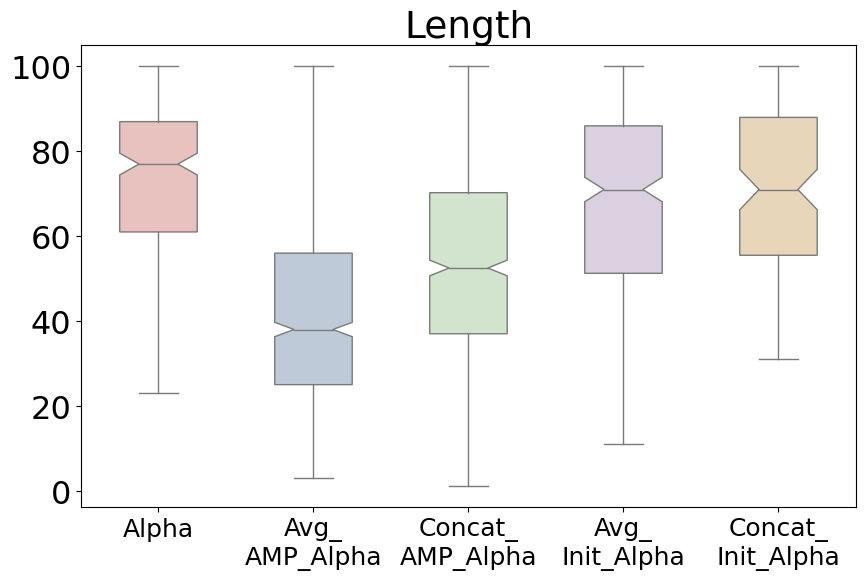

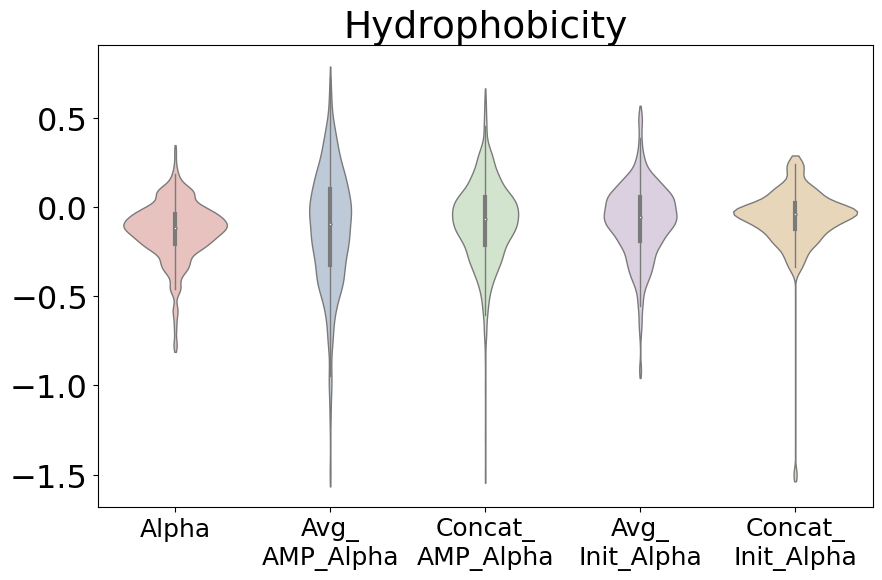

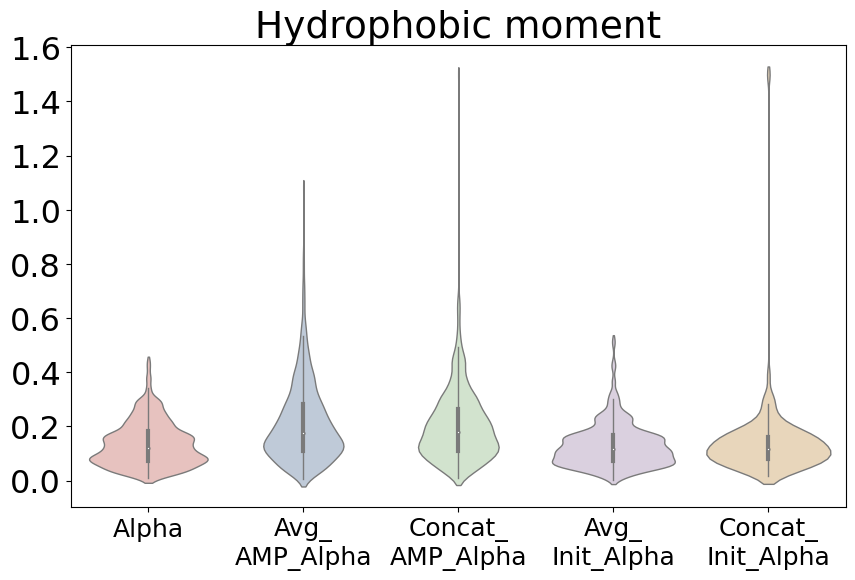

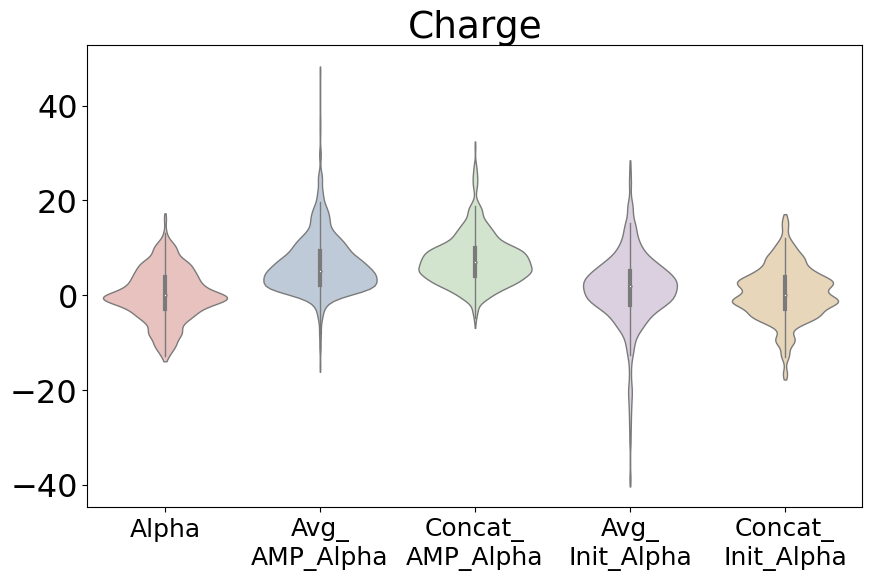

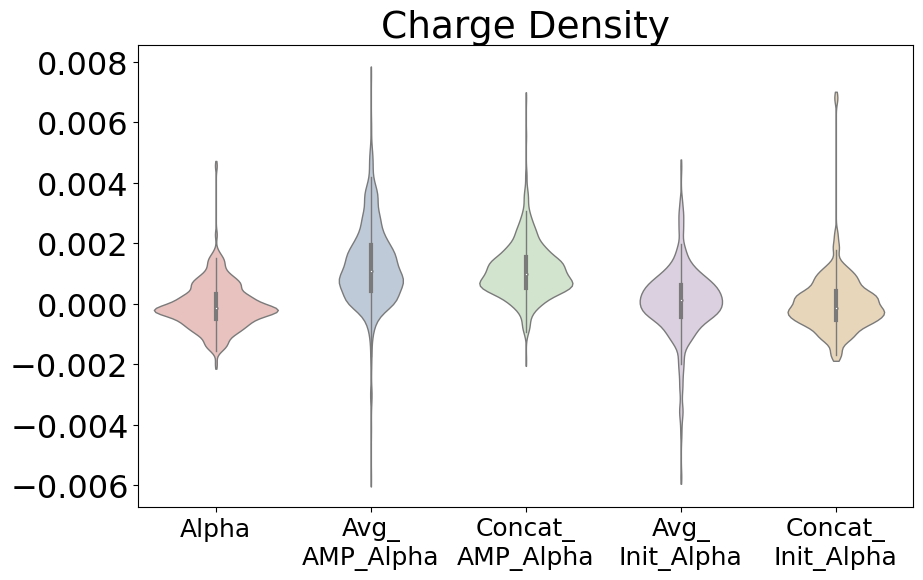

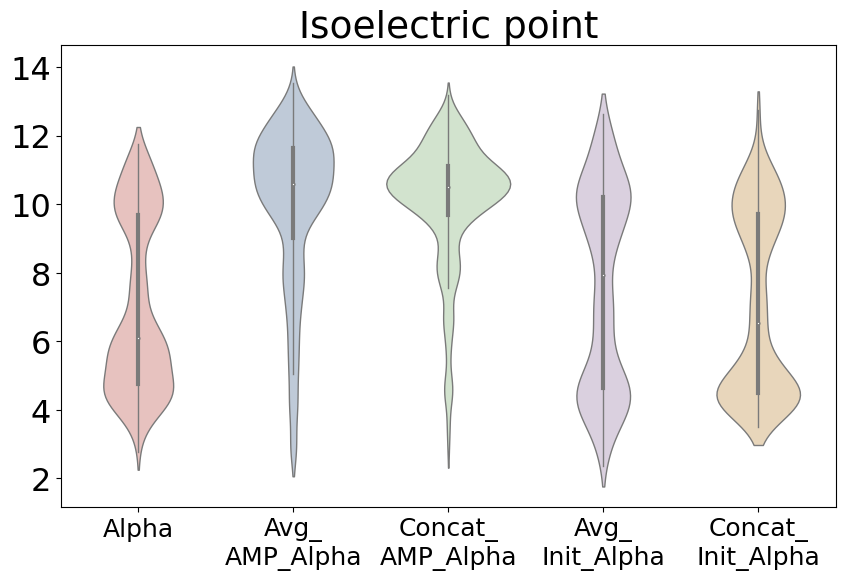

In [21]:
feature_all_list = ['Length', 'Hydrophobicity', 'Hydrophobic moment', 'Charge', 'Charge Density', 'Isoelectric point']

COLOR_SCALE = ["#8ecfc9", "#ffbe7a", "#fa7f6f", '#82b0d2', '#aeadd3']
COLOR_SCALE = ["#edbdb9", "#bbcadc", "#d0e6cb", '#dbcee1', '#f0d8b3']

import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd

for i, item in enumerate(feature_all_list):
    f = plt.figure(figsize=(10, 6))
    c = pd.DataFrame({'Alpha':prefix_alpha_vt20_property_df[item], 'Avg_\nAMP_Alpha':avg_prefix_alpha_amp_property_df[item],  'Concat_\nAMP_Alpha': concat_prefix_amp_alpha_property_df[item], 'Avg_\nInit_Alpha': avg_prefix_alpha_init_property_df[item], 'Concat_\nInit_Alpha': concat_prefix_init_alpha_property_df[item]})
    # c = pd.DataFrame({'AMP':prefix_amp_vt20_property_df[item], 'Alpha':prefix_alpha_vt20_property_df[item], 'Avg_\nAlpha_AMP':avg_prefix_alpha_amp_vt20_property_df[item]})

    if item == 'Length':
        sns.boxplot(data=c,palette=COLOR_SCALE, linewidth=1, width=0.5, notch=True,showfliers=False)
    else:
        sns.violinplot(data=c,palette=COLOR_SCALE, bw=.2, cut=1, linewidth=1)

    plt.xticks(fontsize=18)  # 设置x轴刻度字体大小
    plt.yticks(fontsize=23)  # 设置y轴刻度字体大小

    plt.title(feature_all_list[i], fontsize=27)
    if item == 'Length':
        pass
        f.savefig(f'/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/AMP2/01-img/concat/{item}.svg', transparent=True)
    plt.show()


In [5]:
import numpy as np
x = np.load('/geniusland/home/luojiawei1/project2023/prefix_tuning/generate/Allalpha/1-vt-test/prefix_PREFIX_TUNING_CAUSAL_LM_E100_LR0.001_BS8_ML512_VT10_mxlen500_topk500.npy')
print(x)

['NYVRFHYSQDLLGRLLELSKTNPEFGNLVQKQIITEHESDPEFIEKFSPYLKQEYTKGSGLYNNFRAMLTSLVPDVLLQKEMRAKSKGEKKPY'
 'AKARLPPIYRHLDELFGDLGDPFGHDMNTRTVIREERYNWPNCNAMLEMAKHYCRNTKPKPLPACDHHGDQKENCQLFLSYKCFCENDVALAYKHCITKPKGSRGRVLVVSSSCGAIWPVIDWPCTWLFKWNVGQKALDELYYAQCKGDNP\n'
 'ENIVNPIAILAELVNAEPMKIRAMPFGRMAQMMLADHHHETFRFLKIPLGDNVLSALRAFHAIHGFKLLPAVLDHVYASGRDVMRILMEEFMKVCDLSDKAAVQLYNKVKPWYAPEFEKAKAIFDEVVKNGEHFIMADNQHPIQTWIKTAYWAAHAYSHYLTRLIVRAARAVVLMEGLPEDQSNYVYDFGSEWSRIVTLMQDPHFMTWLKPQVLHWLEGITSRLKAIDSPELIRACRYALVKLQKLPGDLTPKQLSKCGIQTPAQSARIELATLELEPLIVEDFHQVPRIYKKKWKYEGSTASASGLPELDTDTISTPSYMNDKKLSSTPLANNNLPNQ'
 ... 'MATPTTNLQIRLDATVVERLSLLASATGRTKGYIVRAAIDEYIERHRRENV\n'
 'DHMNTHREQWAITRLSTLLAQAQAPLRDALLLALLDTEQRSVDELKGQFRLSYPAVLMHLGALKQLGIVRQERRAGRQQAYSLNADGQAWLQSQLSALLRKLHELHQQERQSLDQLLELEGIL'
 'MPGHHHHHHGSADLSYQPTTLSEIQQLLLTDNFPDKCQVAAQAIGNLSSEADCQEVLVQWGAIPAIVSLLGSSHLRVICCALSTLTMTCNASIHQQLISAQGGLETLVSFLKRTHTQVALEMLRLLNLLAENSTVAARMRMEGVIAPLTALVGAQDPASRHLAAMVFYQLSMEESAQDLVSREGVLHALVGLLTDPAEEVARNAAAVIRKMVT

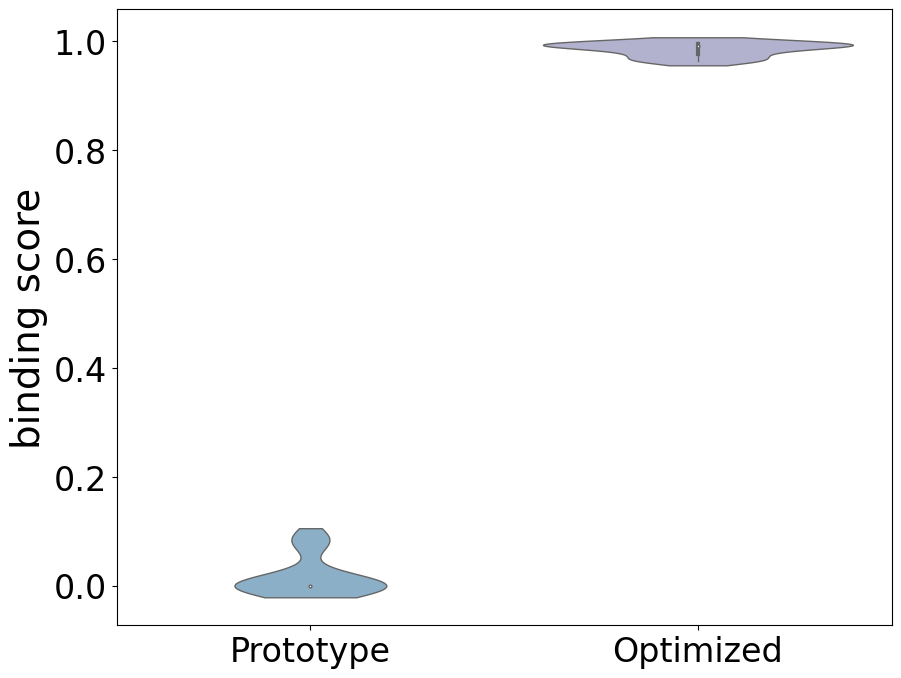

In [1]:
import seaborn as sns
from matplotlib import pyplot as plt
params = {
    'axes.labelsize': 24,
    'axes.titlesize':24,
    'font.size': 24, 
    'legend.fontsize': 24,
    'xtick.labelsize': 24, 
    'ytick.labelsize': 24,
}
plt.rcParams.update(params)
f = plt.figure(figsize=(10,8))

# COLOR_SCALE = ["#8ecfc9", "#ffbe7a", "#fa7f6f", '#82b0d2', '#aeadd3']
COLOR_SCALE = ['#82b0d2','#aeadd3']
    
ax = sns.violinplot(data=[
[
    0.0843430608510971, 
    0.00023973143834155053,
    3.0799678363280236e-09,
    2.4142307597507795e-10,
    0.0840369239449501, 
    8.52697849040851e-05,
    4.8755620809970424e-05,
    1.2838455631936085e-07,
    3.747144261545543e-10,
    1.6060799680417404e-05
],
    
[
    0.9951567053794861, 
    0.9825869202613831, 
    0.9941210150718689, 
    0.9640046954154968, 
    0.9997876286506653, 
    0.9756808280944824,
    0.9968826770782471,
    0.9922366738319397,
    0.9657377004623413,
    0.99104905128479
]
], 
bw=.6, cut=1, linewidth=1, palette=COLOR_SCALE)

ax.set_xticklabels(['Prototype', 'Optimized'])

ax.set_ylabel('binding score', fontsize=28)

plt.savefig('figure/binding_score.pdf')